In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#/kaggle/input/aspen-hysys-distillation-column-data/Distillation Column Dataset.xlsx
#First we have to import packages

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
df = pd.read_csv("distillation.csv")
df.head()

,Time,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,Sensor10,Sensor11,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,MoleFractionTX,MoleFractionHX
0,0,49.718959,101.414959,49.718959,3693.858959,6695.368959,2924.818959,1048.588959,0.054394,0.501001,0.498999,76.803959,104.148959,110.216959,67.038059,0.798463,0,0.966281,0.033719
1,30,49.561845,100.962045,49.541545,3712.947045,6629.637045,2767.487045,1046.987045,0.054233,0.501001,0.498999,76.437645,103.977045,110.045045,66.866145,0.800811,0,0.965788,0.034212
2,60,50.189365,101.490865,50.145165,3718.008865,6692.598865,2763.018865,1050.988865,0.053941,0.501001,0.498999,77.041465,104.608865,110.676865,67.497965,0.803544,0,0.965758,0.034242
3,90,50.183496,101.403296,50.142796,3721.819296,6702.869296,2754.009296,1051.449296,0.053968,0.501001,0.498999,77.016096,104.609296,110.677296,67.498396,0.807065,0,0.965756,0.034244
4,120,50.428793,101.603693,50.406093,3724.444693,6710.444693,2744.244693,1052.674693,0.054121,0.501001,0.498999,77.252293,104.864693,110.932693,67.753793,0.811774,0,0.965784,0.034216


In [3]:
# checking null values 
df.isnull().sum()

Time              0
Sensor1           0
Sensor2           0
Sensor3           0
Sensor4           0
Sensor5           0
Sensor6           0
Sensor7           0
Sensor8           0
Sensor9           0
Sensor10          0
Sensor11          0
Sensor12          0
Sensor13          0
Sensor14          0
Sensor15          0
Sensor16          0
MoleFractionTX    0
MoleFractionHX    0
dtype: int64

In [4]:
#So these data are not useful I think, Feed mole concentration is constant during the operation. 
#The Duties Summary is "0". Mostly duty summary is a report about the distillation column efficiency and maintenance details


for col in df.columns:
    if len(df[col].unique()) == 1:
        print( {col} )

{'Sensor9'}
{'Sensor10'}
{'Sensor16'}


In [5]:
df=df.drop(['Sensor9'], axis=1)
df=df.drop(['Sensor10'], axis=1)
df=df.drop(["Sensor16"], axis=1)
df.head()

,Time,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor11,Sensor12,Sensor13,Sensor14,Sensor15,MoleFractionTX,MoleFractionHX
0,0,49.718959,101.414959,49.718959,3693.858959,6695.368959,2924.818959,1048.588959,0.054394,76.803959,104.148959,110.216959,67.038059,0.798463,0.966281,0.033719
1,30,49.561845,100.962045,49.541545,3712.947045,6629.637045,2767.487045,1046.987045,0.054233,76.437645,103.977045,110.045045,66.866145,0.800811,0.965788,0.034212
2,60,50.189365,101.490865,50.145165,3718.008865,6692.598865,2763.018865,1050.988865,0.053941,77.041465,104.608865,110.676865,67.497965,0.803544,0.965758,0.034242
3,90,50.183496,101.403296,50.142796,3721.819296,6702.869296,2754.009296,1051.449296,0.053968,77.016096,104.609296,110.677296,67.498396,0.807065,0.965756,0.034244
4,120,50.428793,101.603693,50.406093,3724.444693,6710.444693,2744.244693,1052.674693,0.054121,77.252293,104.864693,110.932693,67.753793,0.811774,0.965784,0.034216


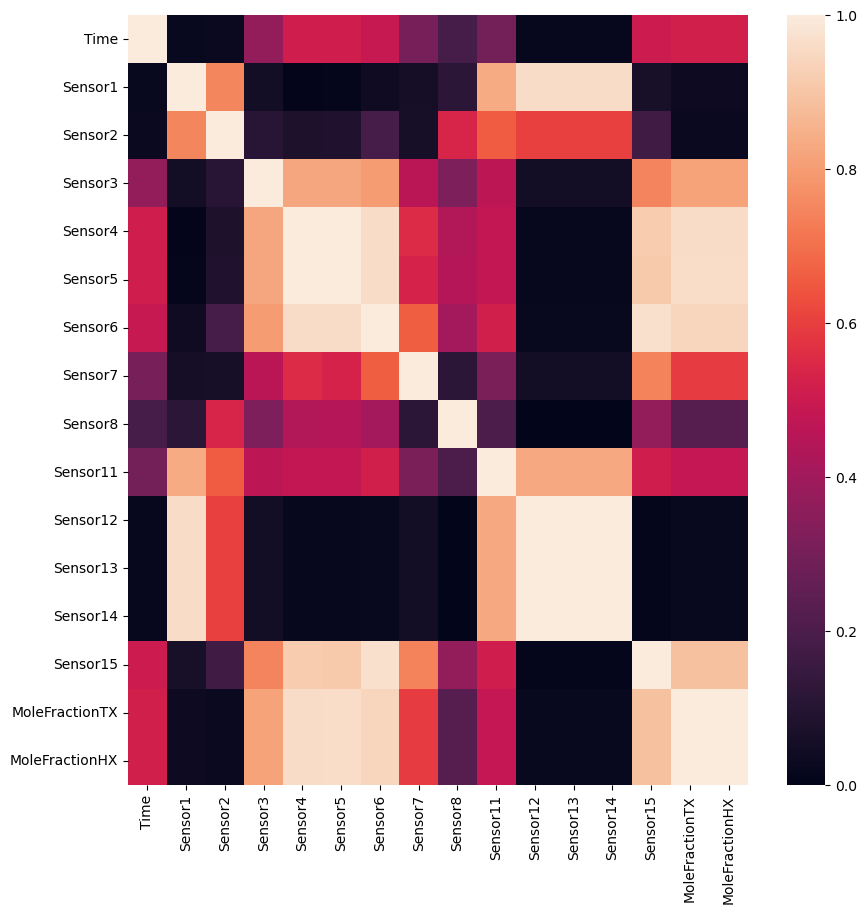

In [6]:
fig, ax = plt.subplots(figsize = (10,10))
#sns.color_palette("magma", as_cmap=True)
sns.heatmap(abs(df.corr()),vmin=0, vmax=1)
plt.show()

Since it is a binary distillation data we need only one mole fraction data. I take TX for the training and testing. But not without a testing. If the sum of HX and TX is 1 for all rows we can remove one of them

In [7]:
df["tot"]=df["MoleFractionTX"]+df["MoleFractionHX"]
df['tot'].all() == 1

True

In [8]:
Column=df[["Time","Sensor3","Sensor4","Sensor5","Sensor6","Sensor7","Sensor8","Sensor15","MoleFractionTX"]]
Column

,Time,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor15,MoleFractionTX
0,0,49.718959,3693.858959,6695.368959,2924.818959,1048.588959,0.054394,0.798463,0.966281
1,30,49.541545,3712.947045,6629.637045,2767.487045,1046.987045,0.054233,0.800811,0.965788
2,60,50.145165,3718.008865,6692.598865,2763.018865,1050.988865,0.053941,0.803544,0.965758
3,90,50.142796,3721.819296,6702.869296,2754.009296,1051.449296,0.053968,0.807065,0.965756
4,120,50.406093,3724.444693,6710.444693,2744.244693,1052.674693,0.054121,0.811774,0.965784
...,...,...,...,...,...,...,...,...,...
956,28680,54.520579,3783.434579,6808.374579,2782.764579,1052.594579,0.054906,0.792092,0.964851
957,28710,55.073908,3783.905308,6809.155308,2782.875308,1053.235308,0.054913,0.792288,0.964852
958,28740,55.234278,3784.033378,6809.343378,2783.673378,1053.403378,0.054925,0.792515,0.964853
959,28770,54.974485,3783.671285,6808.931285,2782.991285,1053.181285,0.054930,0.792525,0.964853


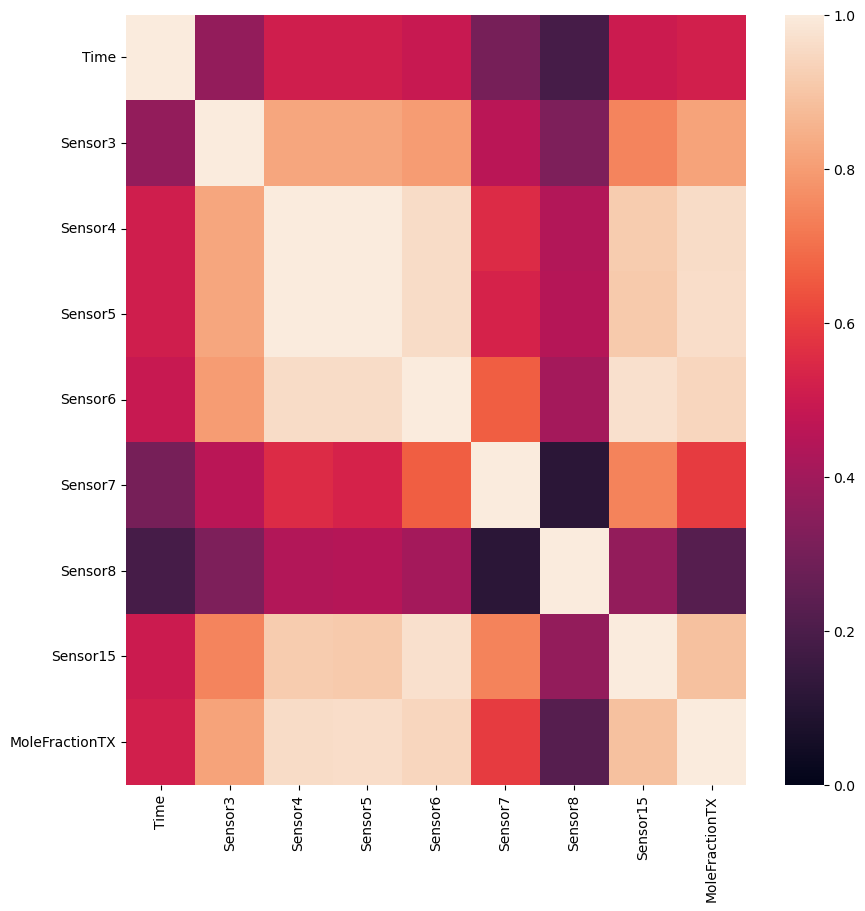

In [9]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(abs(Column.corr()),vmin=0, vmax=1)
plt.show()

In [10]:
x = Column.iloc[:,0:8]
y = Column[["MoleFractionTX"]]
x

,Time,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor15
0,0,49.718959,3693.858959,6695.368959,2924.818959,1048.588959,0.054394,0.798463
1,30,49.541545,3712.947045,6629.637045,2767.487045,1046.987045,0.054233,0.800811
2,60,50.145165,3718.008865,6692.598865,2763.018865,1050.988865,0.053941,0.803544
3,90,50.142796,3721.819296,6702.869296,2754.009296,1051.449296,0.053968,0.807065
4,120,50.406093,3724.444693,6710.444693,2744.244693,1052.674693,0.054121,0.811774
...,...,...,...,...,...,...,...,...
956,28680,54.520579,3783.434579,6808.374579,2782.764579,1052.594579,0.054906,0.792092
957,28710,55.073908,3783.905308,6809.155308,2782.875308,1053.235308,0.054913,0.792288
958,28740,55.234278,3784.033378,6809.343378,2783.673378,1053.403378,0.054925,0.792515
959,28770,54.974485,3783.671285,6808.931285,2782.991285,1053.181285,0.054930,0.792525


In [11]:
Column['Time'] = MinMaxScaler().fit_transform(np.array(Column['Time']).reshape(-1,1))

C:\Users\sumit\AppData\Local\Temp\ipykernel_18012\2788715829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Column['Time'] = MinMaxScaler().fit_transform(np.array(Column['Time']).reshape(-1,1))


In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2 , random_state = 0)
y_train

,MoleFractionTX
751,0.976129
363,0.951786
62,0.965932
79,0.965918
653,0.971220
...,...
835,0.977169
192,0.958372
629,0.971212
559,0.970910


In [13]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state = 1) 
regressor.fit(x_train,y_train)
y_pred=regressor.predict(x_test)
y_pred

array([0.965931, 0.971178, 0.965931, 0.970839, 0.963962, 0.952547,
       0.971214, 0.970023, 0.971223, 0.951861, 0.965938, 0.969311,
       0.964252, 0.951848, 0.976696, 0.951781, 0.951782, 0.95185 ,
       0.964871, 0.951782, 0.970988, 0.976989, 0.964969, 0.965122,
       0.953728, 0.951781, 0.958301, 0.951782, 0.95182 , 0.977089,
       0.971223, 0.965072, 0.971221, 0.970023, 0.977164, 0.951929,
       0.965911, 0.970655, 0.971175, 0.951782, 0.963962, 0.951784,
       0.964869, 0.971199, 0.971224, 0.971212, 0.964857, 0.958279,
       0.977564, 0.977136, 0.964853, 0.964889, 0.965093, 0.951791,
       0.953793, 0.952771, 0.966214, 0.964851, 0.959308, 0.951785,
       0.951833, 0.951787, 0.971179, 0.958301, 0.951798, 0.965122,
       0.951781, 0.951782, 0.965095, 0.964853, 0.971082, 0.965867,
       0.965928, 0.96592 , 0.971224, 0.966963, 0.964252, 0.965343,
       0.9675  , 0.951782, 0.952149, 0.951783, 0.971165, 0.952494,
       0.975992, 0.965933, 0.971219, 0.966852, 0.977156, 0.951

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

C:\Users\sumit\AppData\Local\Temp\ipykernel_18012\3533714243.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


In [15]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.996311583645465

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)


In [20]:
r2_score(Y_test,Y_pred)

0.983088496584724

In [22]:
Column.corr()

,Time,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor15,MoleFractionTX
Time,1.000000,-0.368683,-0.513477,-0.512541,-0.492081,0.302717,-0.187222,0.500055,0.516353
Sensor3,-0.368683,1.000000,0.822167,0.823246,0.799410,-0.460723,0.317811,-0.745673,-0.815105
Sensor4,-0.513477,0.822167,1.000000,0.998642,0.959892,-0.552521,0.441386,-0.916069,-0.959240
Sensor5,-0.512541,0.823246,0.998642,1.000000,0.959797,-0.529631,0.448470,-0.911593,-0.961166
Sensor6,-0.492081,0.799410,0.959892,0.959797,1.000000,-0.662790,0.409924,-0.969132,-0.941967
Sensor7,0.302717,-0.460723,-0.552521,-0.529631,-0.662790,1.000000,0.117106,0.738440,0.590367
Sensor8,-0.187222,0.317811,0.441386,0.448470,0.409924,0.117106,1.000000,-0.369369,-0.226468
Sensor15,0.500055,-0.745673,-0.916069,-0.911593,-0.969132,0.738440,-0.369369,1.000000,0.887787
MoleFractionTX,0.516353,-0.815105,-0.959240,-0.961166,-0.941967,0.590367,-0.226468,0.887787,1.000000


In [24]:
x_new=Column[['Time','Sensor7','Sensor15']]
y_new=Column['MoleFractionTX']
x_new

,Time,Sensor7,Sensor15
0,0.000000,1048.588959,0.798463
1,0.001042,1046.987045,0.800811
2,0.002083,1050.988865,0.803544
3,0.003125,1051.449296,0.807065
4,0.004167,1052.674693,0.811774
...,...,...,...
956,0.995833,1052.594579,0.792092
957,0.996875,1053.235308,0.792288
958,0.997917,1053.403378,0.792515
959,0.998958,1053.181285,0.792525


In [26]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_new,y_new, test_size = 0.2 , random_state = 0)
y_train

751    0.976129
363    0.951786
62     0.965932
79     0.965918
653    0.971220
         ...   
835    0.977169
192    0.958372
629    0.971212
559    0.970910
684    0.971224
Name: MoleFractionTX, Length: 768, dtype: float64

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

In [28]:
r2_score(Y_test,Y_pred)

0.8570761455397593